# Processing phase-contrast MRI data with Python

In this exercise we are going to learn:

* How to handle MR images stored in DICOM format (Digital Imaging and Communications in Medicine: www.dicomstandard.org) using Python

* How to perform operations on the MR data to obtain quantitative information on blood flow

MR datasets for this exersice were acquired using an ECG-triggered flow sensitive gradient echo pulse sequence. 
The acquisiton starts after the R peak has been detected. Each image (frame) is divided into several segments. Different segments are acquired during consecutive heart cycles until the whole k-space data is acquired. The example below shows a simplified acquisition of 7 frames divided into 3 segments:

![Alt](figures/pc_mri.png "Acquisition")

The flow sensitivity was achieved by using a bipolar gradient pulse along the x-axis (as explained in Lecture 3).
Application of this additional gradient results in phase shifts of moving spins, whereas phase shifts of stationary tissue are compensated for. The phase shift can be expressed with a formula:

$\Phi = \gamma \Delta m v$

where $\gamma$ is the gyromagnetic ratio (in this case of hydrogen), $\Delta m$ is the gradient moment and $v$ is the velocity. The phase shift $\Phi$ (range $[-\pi, \pi]$) is proportional to the velocity of moving spins. During the scan the operator has to tune the pulse sequence to the peak velocity expected in the region of interest before starting the measurement. This is achieved by defining the value of the encoding velocity $v_{enc}$ corresponding to a phase shift of $pi$.
We can calculate the blood velocity using a pixel-wise analysis of the phase information in the region of interest (i.e. pulmonary artery). 

Let's start with importing all required Python packages:

In [3]:
%pip install numpy
%pip install matplotlib
%pip install pydicom

import os
import pydicom
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook

In the next step we want to load the MR data stored in time-resolved datasets comprising magnitude and phase images:

In [4]:
# Data directories
magnDir = "data/magnitude"
phaseDir = "data/phase"

# Function to read DICOM files from a directory
def readDicoms(curDir):
    fileList = [file for file in os.listdir(curDir) if os.path.isfile(os.path.join(curDir,file))]
    fileList = sorted(fileList)
    dcm_stack = []
    numFiles = len(fileList)
    for ii in range(0,numFiles):
        tmpDicom = pydicom.read_file(os.path.join(curDir,fileList[ii]))
        tmpArray = tmpDicom.pixel_array
        tmpArray.astype(float)
        tmpArray = tmpArray.transpose()
        dcm_stack.append(tmpArray)
        
    dcm_array = np.array(dcm_stack)        
    dcm_array = np.swapaxes(dcm_array,0,2)
        
    return dcm_array

# Reading magnitude and phase images
M = readDicoms(magnDir)
P = readDicoms(phaseDir)

# Check datasets dimensions
dim_M = M.shape
dim_P = P.shape

if(dim_M[2]!=dim_P[2]):
    raise('Error: different number of time frames')

sx = dim_P[1]
sy = dim_P[0]
st = dim_P[2]
    
print('Dimensions of the magnitude dataset = ' + str(dim_M))
print('Dimensions of the phase dataset = ' + str(dim_P))

Dimensions of the magnitude dataset = (240, 180, 30)
Dimensions of the phase dataset = (240, 180, 30)


How to extract other relevant information from the DICOM files?

In [5]:
fileList = [file for file in os.listdir(magnDir) if os.path.isfile(os.path.join(magnDir,file))]
tmpDicom = pydicom.read_file(os.path.join(magnDir,fileList[0]))

print(tmpDicom)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.25659.1614801979.166253
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.2
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_362'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'RETRO', 'DIS2D']
(0008, 0012) Instance Creation Date              DA: '20200129'
(0008, 0013) Instance Creation Time              TM: '103532.052000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage

We need to know the heart cycle duration (RR value) which is stored in one of the DICOM tags:

In [6]:
tag_string = tmpDicom[0x0020,0x4000].value
print('DICOM tag (0020,4000) : ' + tag_string)
tag_splt = tag_string.split()
rr_value = float(tag_splt[1])

DICOM tag (0020,4000) : RR 981 +/- 15; 21 heartbeats


Let's have a look at the arrays containing image data:

<IPython.core.display.Javascript object>


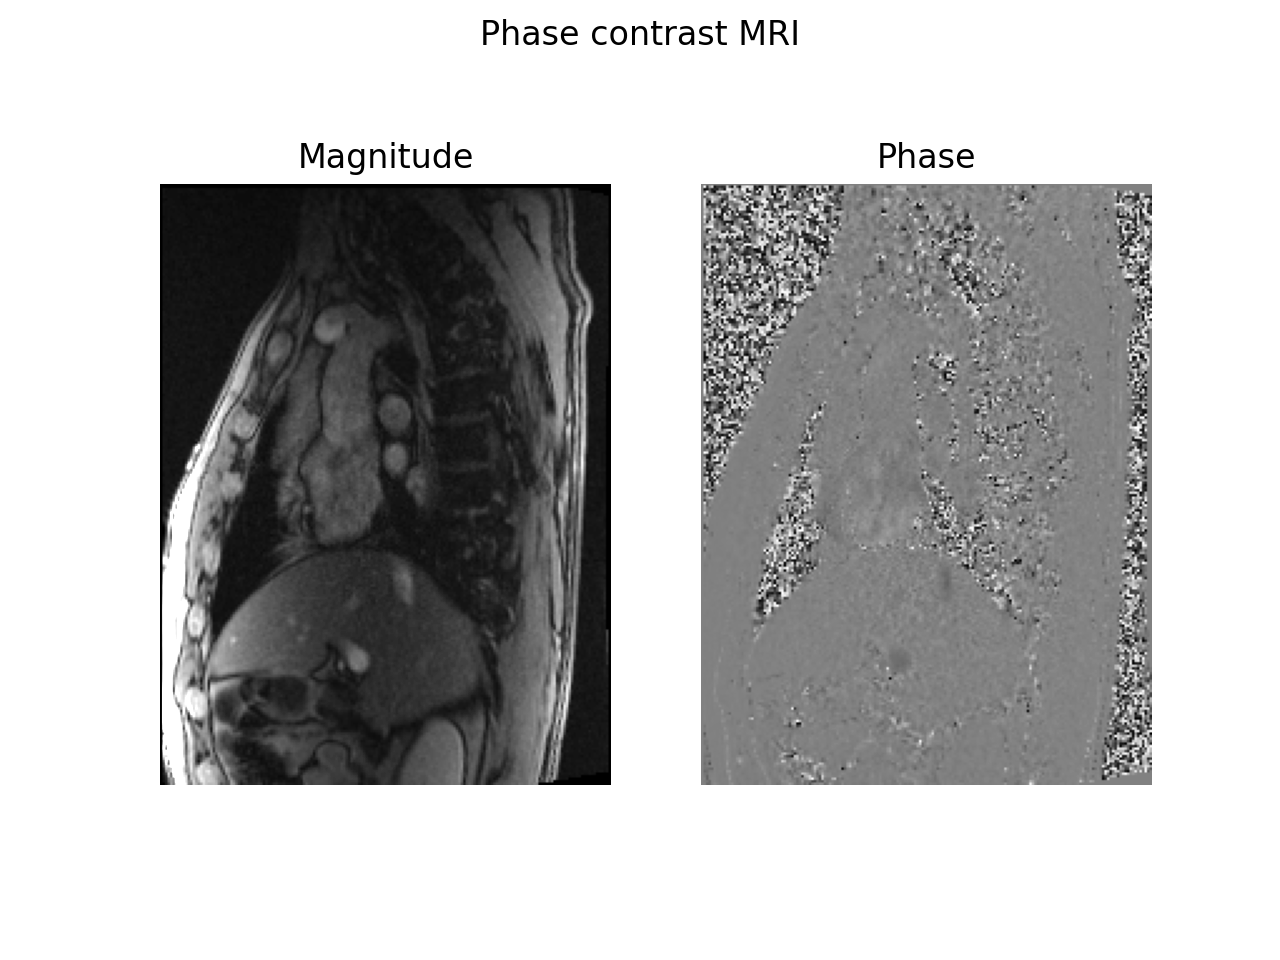

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Phase contrast MRI')

def animate(t):
    ax1.cla()
    ax1.set_title('Magnitude')
    ax1.imshow(M[:,:,t], cmap='gray', vmin=0, vmax=100)
    ax1.set_axis_off()
    ax2.cla()
    ax2.set_title('Phase')
    ax2.imshow(P[:,:,t], cmap='gray', vmin=0, vmax=4055)
    ax2.set_axis_off()

matplotlib.animation.FuncAnimation(fig, animate, frames=st)

Now we can define a region of interest in pulmonary aorta (we can check the coordinates in the previous section).

<IPython.core.display.Javascript object>


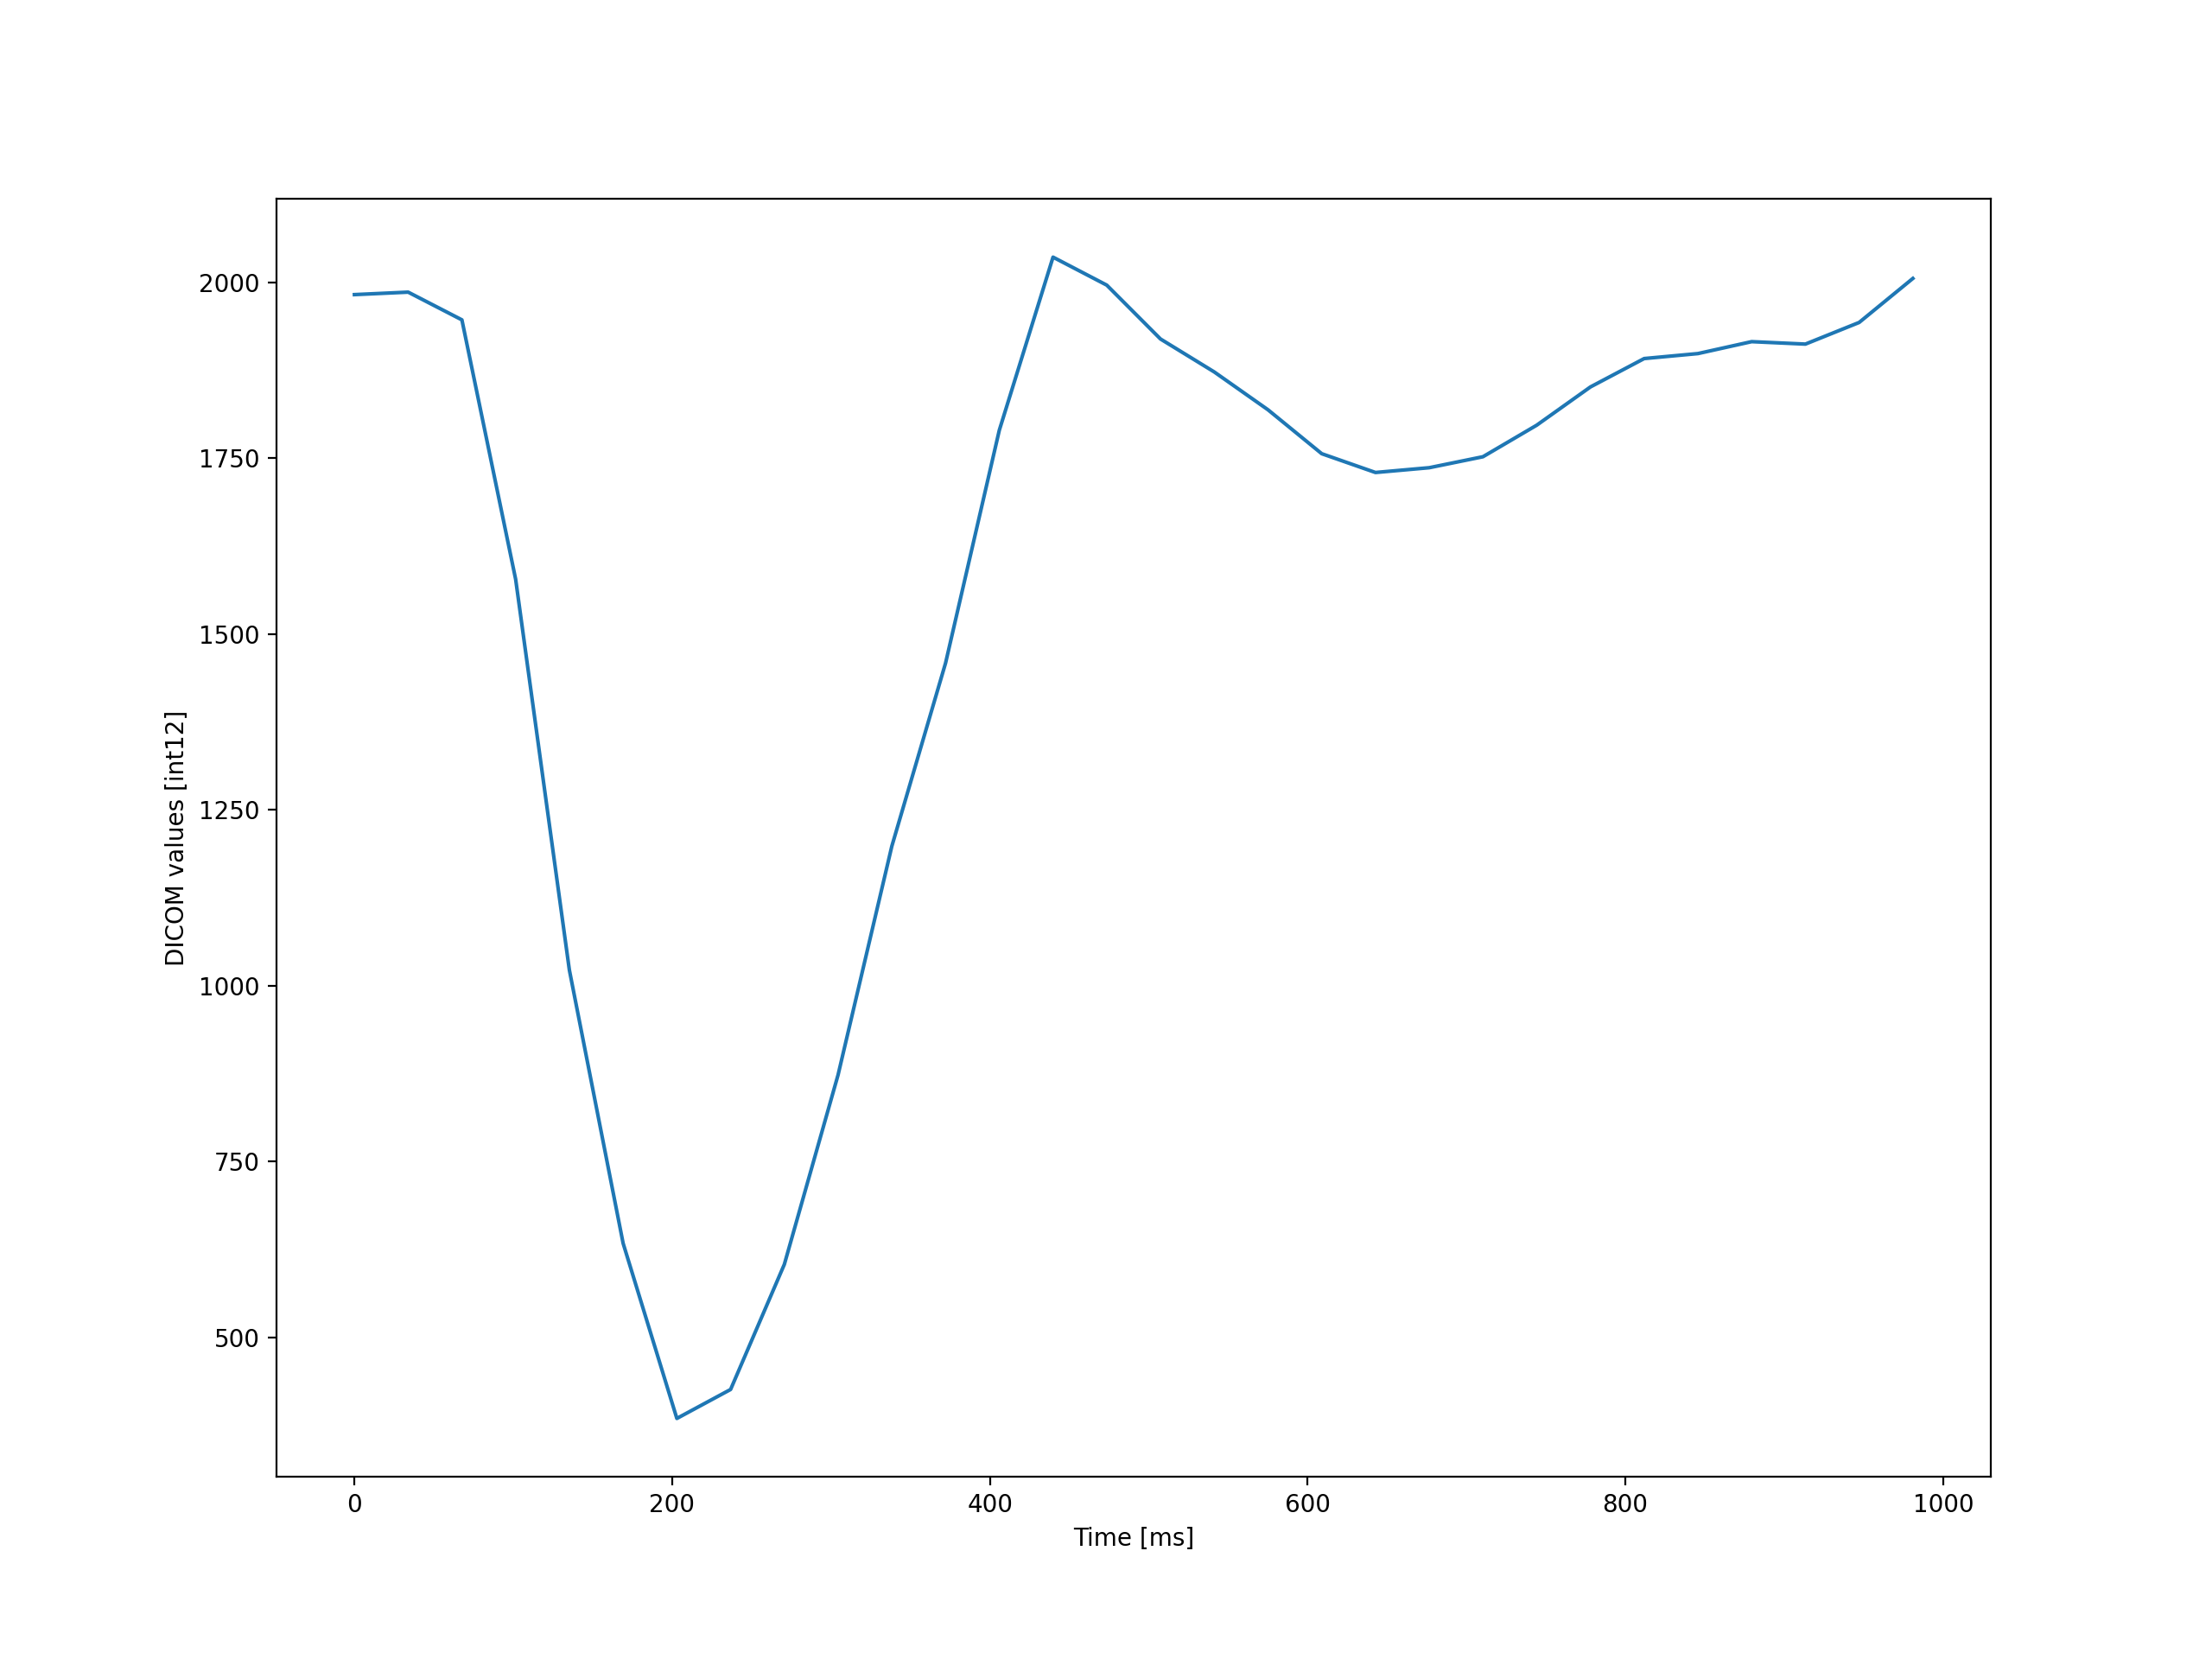

In [8]:
def get_roi_timecourse(arr, xc, yc, rad):

    sig_sum = np.zeros(st)

    for tt in range(0,st):
        cnt = 0
        for ii in range(xc-rad,xc+rad+1):
            for jj in range(yc-rad,yc+rad+1):
                dist = np.sqrt((ii-xc)**2 + (jj-yc)**2)
                if(dist<rad):
                    sig_sum[tt] += arr[jj,ii,tt]
                    cnt += 1

        sig_sum[tt] /= cnt
    
    return sig_sum
                
# Define our ROI parameters
roi_x = 93
roi_y = 91
radius = 3
                        
xtime = np.linspace(0, rr_value, st)        
phase_timecourse = get_roi_timecourse(P, roi_x, roi_y, radius)

fig = plt.figure()
plt.plot(xtime,phase_timecourse)
plt.xlabel('Time [ms]')
plt.ylabel('DICOM values [int12]')
plt.show()

Voxel values are stored as integers using usually 12-bit depth (0,4095) or 16-bit depth (0,65535).
We have to rescale the voxel values knowing that the minimal value 0 corresponds to $\Phi = -\pi$ or $v_{enc} = -150 [cm/s]$ and the maximal value 4095 to $\Phi = \pi$ or $v_{enc} = 150 [cm/s]$,

<IPython.core.display.Javascript object>


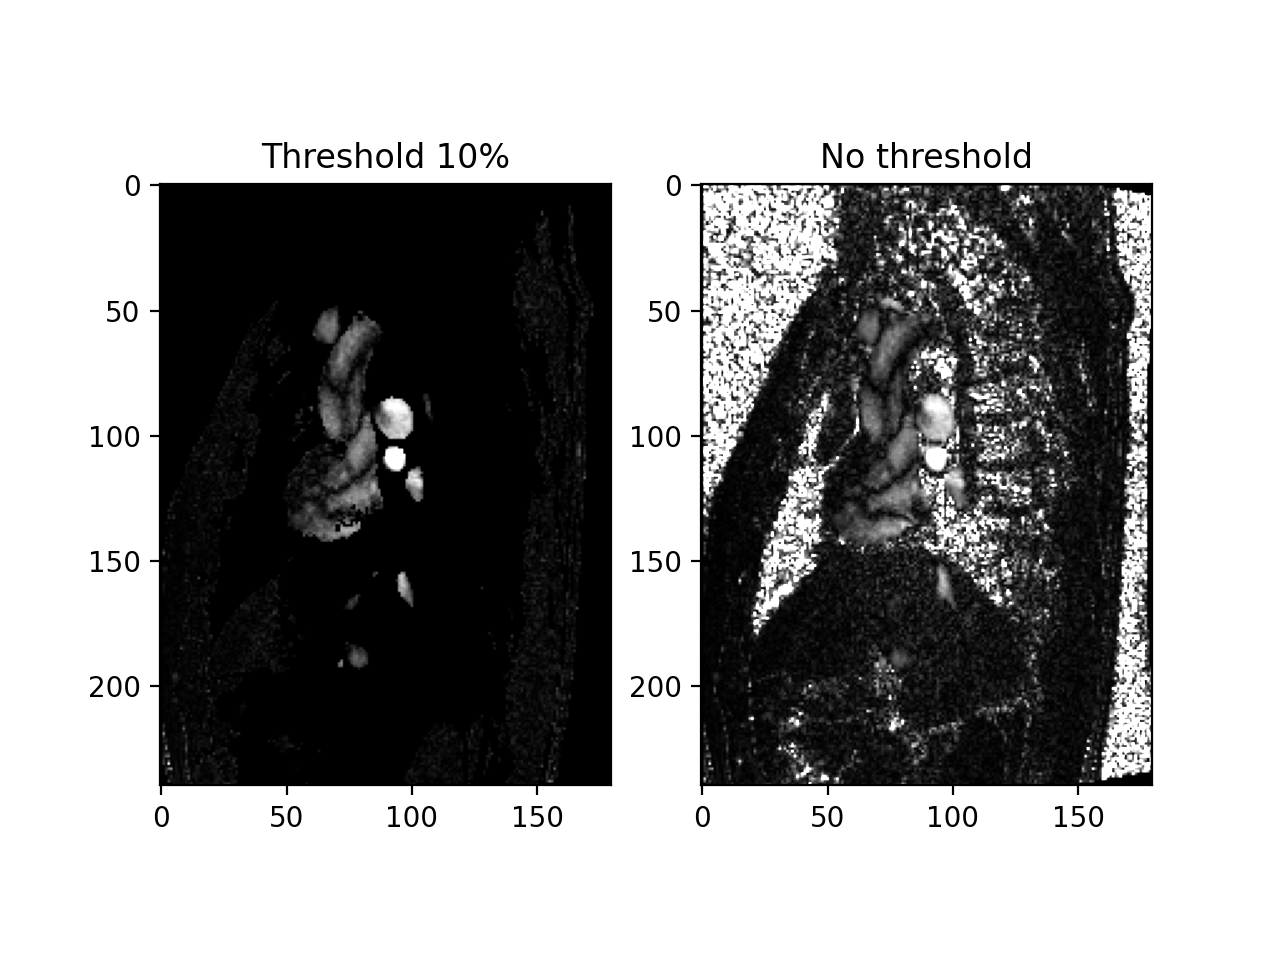

In [9]:
# Scale values to [cm/s]
V = P - 2048.0
V = np.abs(V)/2048.0*150.0
V_old = np.copy(V)

# Discard voxels, where magnitude is below 10% of the maximum value
max_M = M.max()
thresh_M = max_M*0.1

for ii in range(0,sx):
    for jj in range(0,sy):
        for tt in range(0,st):
            if(M[jj,ii,tt]<thresh_M):
                V[jj,ii,tt] = 0.0
                
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Threshold 10%')
ax1.imshow(V[:,:,10], cmap='gray', vmin=0, vmax=70)
ax2.set_title('No threshold')
ax2.imshow(V_old[:,:,10], cmap='gray', vmin=0, vmax=70)
plt.show()

<IPython.core.display.Javascript object>


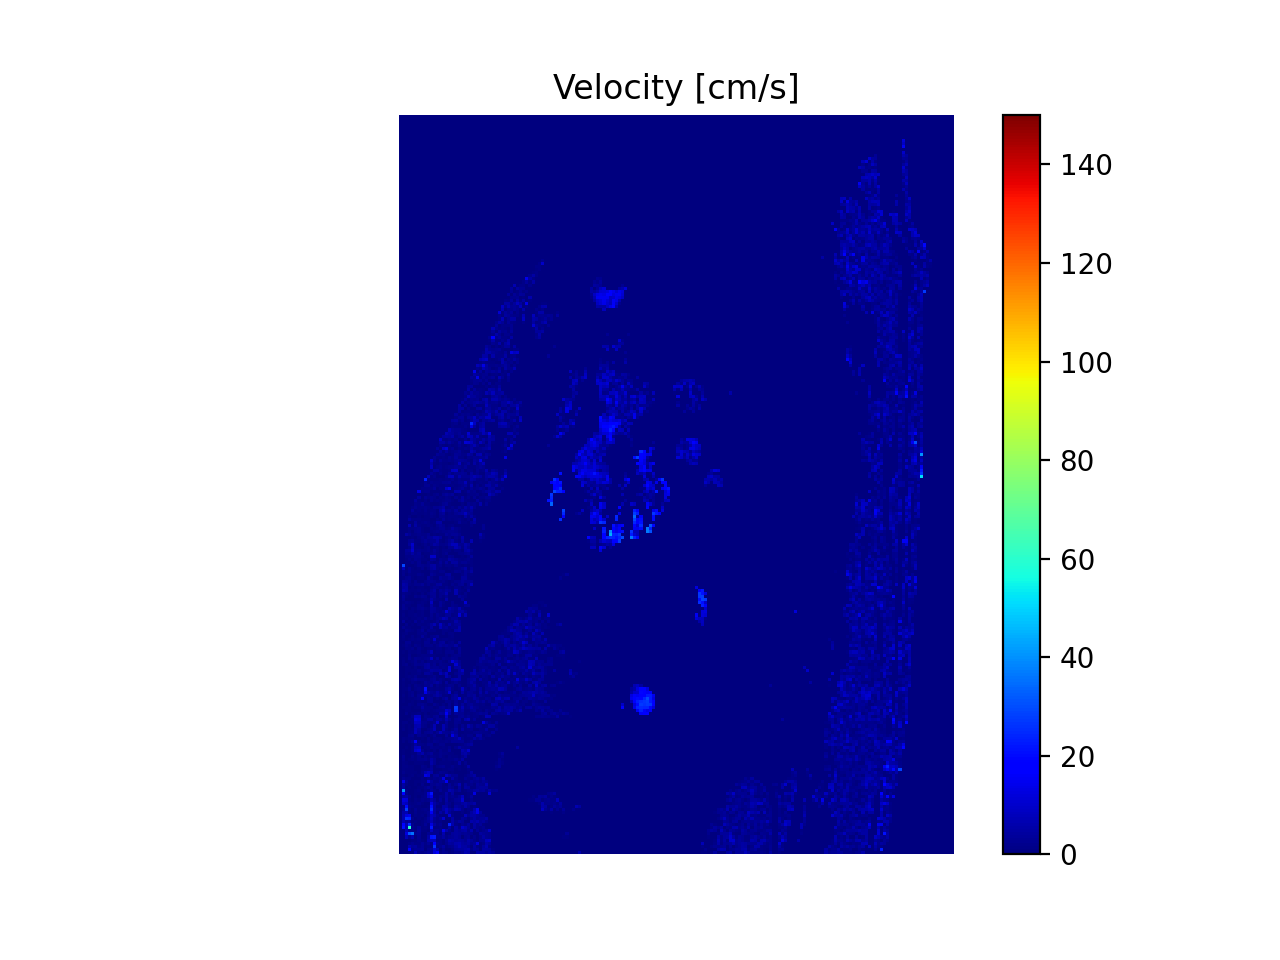

In [22]:
fig, ax = plt.subplots(1)
cs = ax.imshow(V[:,:,0], cmap='jet', vmin=0, vmax=150)
cbar = fig.colorbar(cs)

def animate_velocity(t):
    ax.cla()
    ax.set_title('Velocity [cm/s]')
    cs = ax.imshow(V[:,:,t], cmap='jet', vmin=0, vmax=150)
    ax.set_axis_off()
    
matplotlib.animation.FuncAnimation(fig, animate_velocity, frames=st, repeat=True, repeat_delay=0)

Plot the blood velocity in the pulmonary artery.

<IPython.core.display.Javascript object>


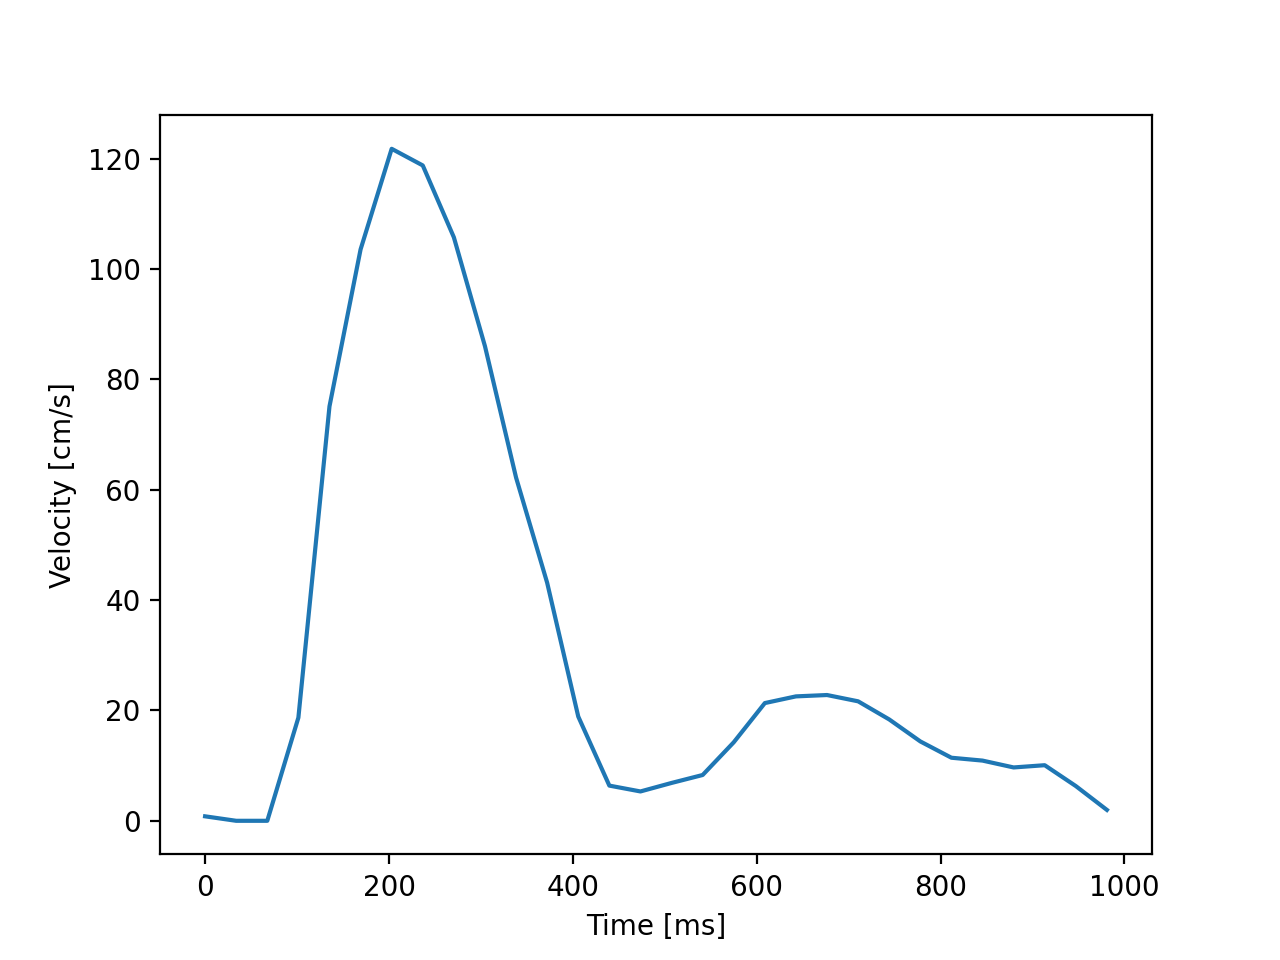

In [23]:
v_timecourse = get_roi_timecourse(V, roi_x, roi_y, radius)

fig = plt.figure()
plt.plot(xtime,v_timecourse)
plt.xlabel('Time [ms]')
plt.ylabel('Velocity [cm/s]')
plt.show()